In [1]:
import os, sys, imageio, math, scipy
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import raw_process4 as raw_process
from pylab import imshow, show
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [2]:
with open("chart.jpg", "rb") as input_file:
    data = input_file.read()
data = data[-10237440:]

In [3]:
w = 3282  # for v1.3 w = 2592
h = 2480 - 32 # for v1.3 h = 1944

In [4]:
img = np.zeros((h, w))
stride = math.ceil(w * 10 / 8 / 32) * 32
for y in range(h):
    for x in range(w // 4):
        word = data[y * stride + x * 5: y * stride + x * 5 + 5]
        img[y, 4 * x    ] = (word[0] << 2) | ((word[4] >> 6) & 3) 
        img[y, 4 * x + 1] = (word[1] << 2) | ((word[4] >> 4) & 3) 
        img[y, 4 * x + 2] = (word[2] << 2) | ((word[4] >> 2) & 3) 
        img[y, 4 * x + 3] = (word[3] << 2) | ((word[4]     ) & 3)

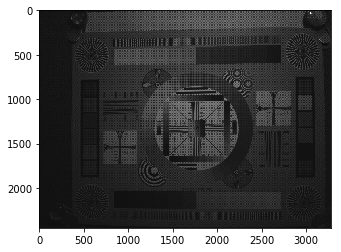

In [5]:
outimg = img.copy()
outimg[outimg < 0] = 0
outimg[outimg > 1023] = 1023
outimg = outimg / 1024
imshow(outimg, cmap='gray')

In [6]:
blacklevel = [64] * 4
bayer_pattern = np.array([[2, 1], [1, 0]])
blc_raw = raw_process.black_level_correction(img, blacklevel)

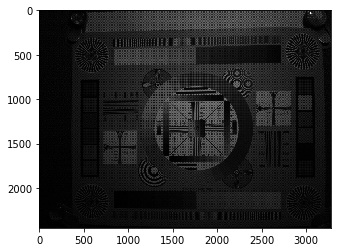

In [7]:
outimg = blc_raw.copy()
outimg = outimg.reshape((h, w))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg, cmap='gray')

In [8]:
patches = [(2586, 2086), (2430, 2092), (2272, 2090), (2112, 2090), (1958, 2086), (1792, 2094), 
           (1642, 2096), (1486, 2090), (1328, 2090), (1172, 2086), (1016,2084), (860, 2084),
           (866, 482), (1022, 480), (1172, 476), (1328, 474), (1480, 470), (1634, 466),
          (1788, 462), (1944, 460), (2110, 452), (2266, 452), (2424, 448), (2586, 442)]

In [9]:
variances = []
averages = []
for index, (dx, dy) in enumerate(((0, 0), (1, 0), (0, 1), (1, 1))):
    for patch in patches:
        x, y = patch
        p = blc_raw[y+dy:y+100:2, x+dx:x+100:2]
        s2 = (p * p).mean()
        av = p.mean()
        v = s2 - av * av
        variances.append(v)
        averages.append(av)

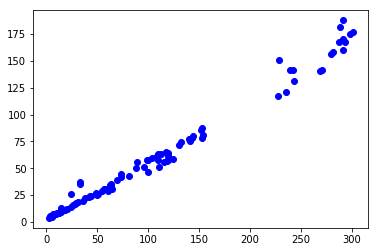

In [10]:
plt.plot(averages, variances, linestyle='None', marker='o', color='blue')
plt.show()

In [11]:
par = np.polyfit(averages, variances, 1)
print(par)

[0.56437789 0.11695864]


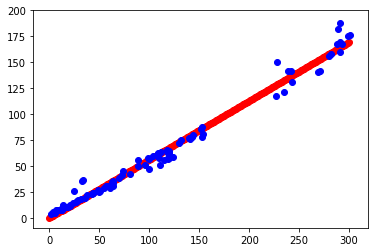

In [12]:
xs = np.linspace(0, 300, 300)
ys = par[0] * xs + par[1]
plt.scatter(xs, ys, color = 'red')
plt.scatter(averages, variances, color = 'blue')
plt.show()

In [13]:
par = [np.array([6.07106808e-07, 9.60556906e-01]), 
       np.array([6.32044369e-07, 9.70694361e-01]), 
       np.array([6.28455183e-07, 9.72493898e-01]), 
       np.array([9.58743579e-07, 9.29427169e-01])]

In [14]:
gain_map = np.zeros((h, w))
center_y, center_x = h // 2, w // 2
for y in range(0, h, 2):
    for x in range(0, w, 2):
        r2 = (y - center_y) * (y - center_y) + (x - center_x) * (x - center_x)
        gain = [par[i][0] * r2 + par[i][1] for i in range(4)]
        gain_map[y, x] = gain[0]
        gain_map[y, x+1] = gain[1]
        gain_map[y+1, x] = gain[2]
        gain_map[y+1, x+1] = gain[3]

In [15]:
lsc_raw = blc_raw * gain_map

In [16]:
wbg = np.array([1.128, 1, 2.546, 1])

In [17]:
wb_raw = raw_process.white_balance_Bayer(lsc_raw, wbg, bayer_pattern)

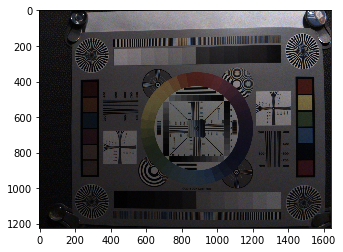

In [18]:
outimg = raw_process.preview_demosaic(wb_raw, bayer_pattern)
outimg[outimg < 0] = 0
outimg[outimg > 1023] = 1023
outimg = outimg / 1024
imshow(outimg, cmap='gray')

In [19]:
dms_img = raw_process.advanced_demosaic(wb_raw, bayer_pattern)

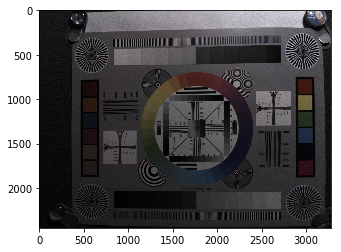

In [20]:
outimg = dms_img.copy()
outimg = outimg.reshape((h, w, 3))
outimg[outimg < 0] = 0
outimg[outimg > 1023] = 1023
outimg = outimg / 1024
imshow(outimg)

In [21]:
luma_img = dms_img[:, :, 0] + dms_img[:, :, 1] + dms_img[:, : , 2]
variances = []
averages = []
for patch in patches:
    x, y = patch
    p = luma_img[y:y+100, x:x+100]
    s2 = (p * p).mean()
    av = p.mean()
    v = s2 - av * av
    variances.append(v)
    averages.append(av)

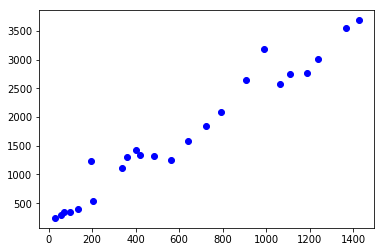

In [22]:
plt.plot(averages, variances, linestyle='None', marker='o', color='blue')
plt.show()

In [41]:
par = np.polyfit(averages, variances, 1)
print(par)

[  2.36138873 246.02813076]


In [24]:
# # 注：これは処理をわかりやすく書いたもので非常に処理が遅い。
# # 実際にはこの後の高速版を使用することをおすすめする
# coef = 8
# img_flt = dms_img.copy()
# for y in range(2, h-2):
#     for x in range (2, w - 2):
#         # 5x5の平均値からノイズの分散(sigma) を推定する
#         average = luma_img[y-2:y+3, x-2:x+3].mean()
#         sigma = par[1] * average
#         sigma = sigma if sigma > 0 else 1

#         weight = np.zeros((5, 5))
#         out_pixel = np.zeros(3)
#         norm = 0
#         # 5x5内の各画素毎に重みを計算する
#         for dy in range(-2, 3):
#             for dx in range(-2, 3):
#                 # 中心画素との差
#                 diff = luma_img[y + dy, x + dx] - luma_img[y, x]
#                 diff_norm = diff * diff / sigma
#                 # 差と分散からウェイトを計算し、加重平均値を求める
#                 weight = math.exp(-coef * diff_norm)
#                 out_pixel += weight * dms_img[y + dy, x + dx, :]
#                 norm += weight
#         # 各色毎にウェイトの和で正規化する
#         img_flt[y, x, 0] = out_pixel[0] / norm
#         img_flt[y, x, 1] = out_pixel[1] / norm
#         img_flt[y, x, 2] = out_pixel[2] / norm

In [25]:
from numpy.lib.stride_tricks import as_strided

In [26]:
coef = 8

In [27]:
average = scipy.ndimage.filters.uniform_filter(luma_img, 5, mode='mirror')
sigma_map = average * par[1]
sigma_map[sigma_map < 1] = 1
sy, sx = sigma_map.strides
sigma_tile = as_strided(sigma_map, strides=(sy, sx, 0, 0), shape=(h, w, 5, 5))
sigma_tile = sigma_tile[2:h-2, 2:w-2, : , :]

In [28]:
sy, sx = luma_img.strides
luma_tile = as_strided(luma_img, strides=(sy, sx, 0, 0), shape=(h, w, 5, 5))
luma_tile = luma_tile[2:h-2, 2:w-2, : , :]
luma_box = as_strided(luma_img, strides=(sy, sx, sy, sx), shape=(h-4, w-4, 5, 5))

In [29]:
diff = luma_box - luma_tile
d2 = diff * diff
weight = np.exp(-coef * diff * diff / sigma_tile)
weight_sum = weight.sum(axis=(2, 3))

In [30]:
red = dms_img[:, :, 0]
sy, sx = red.strides
red_boxes = as_strided(red, strides=(sy, sx, sy, sx), shape=(h-4, w-4, 5, 5))
red_out = (weight * red_boxes).sum(axis=(2, 3)) / weight_sum

In [31]:
green = dms_img[:, :, 1]
sy, sx = green.strides
green_boxes = as_strided(green, strides=(sy, sx, sy, sx), shape=(h-4, w-4, 5, 5))
green_out = (weight * green_boxes).sum(axis=(2, 3)) / weight_sum

In [32]:
blue = dms_img[:, :, 2]
sy, sx = blue.strides
blue_boxes = as_strided(blue, strides=(sy, sx, sy, sx), shape=(h-4, w-4, 5, 5))
blue_out = (weight * blue_boxes).sum(axis=(2, 3)) / weight_sum

In [33]:
img_flt2 = dms_img.copy()
img_flt2[2:h-2, 2:w-2, 0] = red_out
img_flt2[2:h-2, 2:w-2, 1] = green_out
img_flt2[2:h-2, 2:w-2, 2] = blue_out

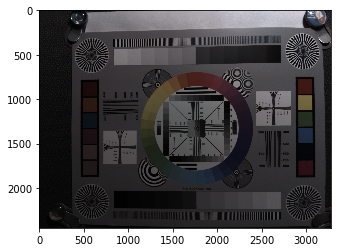

In [34]:
outimg = img_flt2.copy()
outimg = outimg.reshape((h, w, 3))
outimg = outimg / 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
imshow(outimg)

In [35]:
ccm_matrix = (6022,-2314,394,-936,4728,310,300,-4324,8126)
img_ccm = raw_process.color_correction_matrix(img_flt2, ccm_matrix)

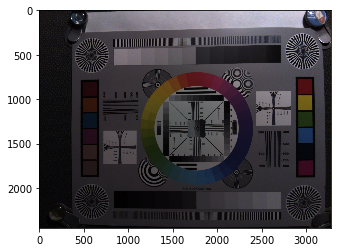

In [36]:
outimg = img_ccm.copy()
outimg = outimg.reshape((h, w, 3))
outimg = outimg / 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
imshow(outimg)

In [37]:
img_ccm[img_ccm > 1023] = 1023
img_gamma = raw_process.gamma_correction(img_ccm, 2.2)

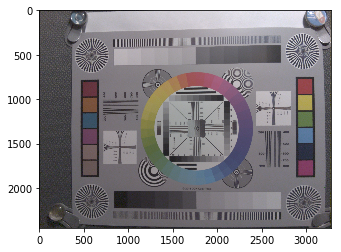

In [38]:
outimg = img_gamma.copy()
outimg = outimg.reshape((h, w, 3))
outimg[outimg < 0] = 0
imshow(outimg)

In [39]:
raw_process.write(img_gamma, "raspi_filtered_out.png")

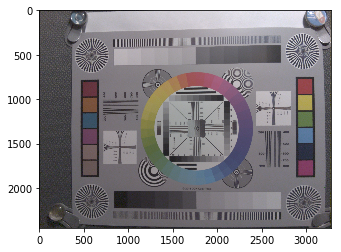

In [40]:
imshow(imageio.imread('raspi_filtered_out.png'))
show()